In [ ]:
def he_converge():
    he = []
    e1 = []
    e2 = []
    e3 = []
    for i in range(6):
        h = 1./2**i
        he.append(h)
        [a,b,c] = main(h)
        e1.append(a)
        e2.append(b)
        e3.append(c)
        
    # converge speed
    slope1 = (np.log(e1[-1])-np.log(e1[0]))/(np.log(he[-1])-np.log(he[0]))
    slope2 = (np.log(e2[-1])-np.log(e2[0]))/(np.log(he[-1])-np.log(he[0]))
    
    # plot dx vs error in loglog
    plt.loglog(he,e1,'-o',he,e2,'-x',he,e3,'-s')
    plt.xlabel("he")
    plt.ylabel("RMS error")
    plt.legend(['potential','u','v'])
    plt.text(0.1,0.1,'slope phi = '+str(slope1))
    plt.text(0.1,0.05,'slope vel = '+str(slope2))
    
def check_ita(ita,h):
    if np.abs(ita)>10.*h:
        sys.exit("wave too high")
    return

def exa_sol(af,L,n,x):
    exa_phi = np.zeros(n)
    exa_u = np.zeros((n,2))
    for i in range(n):
        exa_phi[i] = af*np.sin(math.pi*(x[i][0]-0.5*L)/L)*np.cosh(math.pi*(x[i][1])/L)
        exa_u[i][0] = af*(math.pi/L)*np.cos(math.pi*(x[i][0]-0.5*L)/L)*np.cosh(math.pi*(x[i][1])/L)
        exa_u[i][1] = af*(math.pi/L)*np.sin(math.pi*(x[i][0]-0.5*L)/L)*np.sinh(math.pi*(x[i][1])/L)
    return exa_phi,exa_u
    
def rmse(n,exa,num):
    e = 0.
    for i in range(n):
        e += (exa[i]-num[i])**2
    e = math.sqrt(e/n)
    return e

def contour_plot(nx,ny,x,sol,exa):
    X = np.zeros(nx)
    Y = np.zeros(ny)
    Z_sol = np.zeros((ny,nx))
    Z_exa = np.zeros((ny,nx))
    for i in range(nx):
        X[i] = x[i][0]
    for i in range(ny):
        Y[i] = x[nx*i][1]
    c = 0
    for i in range(ny):
        for j in range(nx):
            Z_sol[i][j] = sol[c]
            Z_exa[i][j] = exa[c]
            c += 1
            
    plt.contour(X, Y, Z_sol, 20, colors='black')
    plt.contour(X, Y, Z_exa, 20, colors='red')
    #plt.legend(['numerical reults','exact function'])
    
def plotMesh(elements, nodes,l2g=False):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(18,9)); plt.rcParams.update({'font.size': 22})
    for eN, e in enumerate(elements):
        element_nodes = nodes[e[0]], nodes[e[1]], nodes[e[2]], nodes[e[3]]
        X = [n[0] for n in element_nodes]; Y = [n[1] for n in element_nodes]
        cx = sum(X)/4.; cy = sum(Y)/4.
        X.append(element_nodes[0][0]); Y.append(element_nodes[0][1])
        plt.plot(X, Y); plt.text(cx, cy, "$T_{{{0:d}}}$".format(eN))
        for n in e:
            plt.text(nodes[n,0], nodes[n,1], "$N_{{{0:d}}}$".format(n))
    #if l2g:
        #plt.text(nodes[n,0], nodes[n,1], "$N_{{ {0:d} = elements[{1:d},{2:d}] = elements[0,1]}}$".format(n,eN,2))
    plt.axis('equal')
    return plt

def mesh(L,h,he,method):
    # element number and size
    nex = int(math.ceil(L/he))
    ney = int(math.ceil(h/he))
    ne = nex*ney
    dx = L/nex
    dy = h/ney
    
    # node number
    nx = nex+1
    ny = ney+1
    n = nx*ny
    
    # mesh method
    if method == 'even':
        xi = np.linspace(0.,L,nx)
        yi = np.linspace(0.,h,ny)
    elif method =='cos':
        xi = np.linspace(0.,L,nx)
        yi = x_cos(0.,h,ny)  
    elif method =='pwr':
        xi = np.linspace(0.,L,nx)
        yi = x_power(0.,h,ny)  
        
    # mesh node
    c = 0
    x = np.zeros((n,2))
    for j in range(ny):
        for i in range(nx):
            x[c][0] = xi[i]
            x[c][1] = yi[j]
            c += 1
            
    # local-global index for triangle mesh (left-down right-up)
    c = 0
    ln = np.zeros((ne,4), dtype=int)
    for j in range(ney):
        for i in range(nex):
            ln[c][0] = nx*j+i
            ln[c][1] = nx*j+i+1
            ln[c][2] = nx*(j+1)+i+1
            ln[c][3] = nx*(j+1)+i
            c += 1
   
    # define global index of the boundary node for solving BVP
    epi = 1.e-6
    idir = []
    ineu1 = []
    ineu2 = []
    ineu3 = []
    for i in range(n):
        if abs(x[i][1]-h) < epi:   # free surface
            idir.append(i)           
        elif abs(x[i][0] - 0) < epi: # left wall
            ineu1.append(i)
        elif abs(x[i][0] - L) < epi: # right wall
            ineu3.append(i)
        elif abs(x[i][1] - 0) < epi: # bottom
            ineu2.append(i)
              
    ndir = len(idir)
    nneu1 = len(ineu1)
    nneu2 = len(ineu2)
    nneu3 = len(ineu3)
    
    # define global index of the free-surface nodes for time marching
    ifs = []
    for i in range(n):
        if abs(x[i][1]-h) <epi:   # free surface
            ifs.append(i)  
    nfs = len(ifs)
    
    return nex,ney,ne,nx,ny,n,ln,ndir,idir,nneu1,ineu1,nneu2,ineu2,nneu3,ineu3,ifs,nfs,x

def x_cos(x0,xn,n):
    x = np.zeros(n)
    r = xn-x0
    ds = 0.5*np.pi/(n-1)
    for i in range(n):
        x[i] = x0+r*np.sin(ds*i)
    return x

def x_power(x0,xn,n):
    w = np.power(np.linspace(0,1,n),0.7)
    s = np.sum(w)
    l = xn-x0
    x = np.zeros(n)
    x[0] = x0
    for i in range(n-1):
        x[i+1] = x[i]+l*w[n-1-i]/s
    return x

def load_phi(n,ndir,idir,phi):
    F = np.zeros(n)
    for i in idir:
        F[i] = phi[i]
    return F

def load_pphi(mov_wall,n,idir,nneu1,ineu1,nneu3,ineu3,x,v1,v3):
    F = np.zeros(n)
    if mov_wall[0]:
        for i in range(nneu1-1):
            le = x[ineu1[i+1],1]-x[ineu1[i],1]
            F[ineu1[i]] += -0.5*v1*le
            F[ineu1[i+1]] += -0.5*v1*le
        le = x[idir[0],1]-x[ineu1[-1],1]
        F[ineu1[-1]] += -0.5*v1*le
    if mov_wall[1]:
        for i in range(nneu3-1):
            le = x[ineu3[i+1],1]-x[ineu3[i],1]
            F[ineu3[i]] += 0.5*v3*le
            F[ineu3[i+1]] += 0.5*v3*le
        le = x[idir[-1],1]-x[ineu3[-1],1]
        F[ineu3[-1]] += 0.5*v3*le
    return F

def loc_nod():  
    # local coordinate of corner nodes
    xc = np.zeros((4,2))
    xc[0,0] = -1.
    xc[1,0] = 1. 
    xc[2,0] = 1. 
    xc[3,0] = -1. 
    xc[0,1] = -1.
    xc[1,1] = -1. 
    xc[2,1] = 1. 
    xc[3,1] = 1. 
    return xc

def Shapefunctions(xi,eta):
    sha = np.zeros(4)
    sha[0] = 0.25*(1-xi)*(1-eta)
    sha[1] = 0.25*(1+xi)*(1-eta)
    sha[2] = 0.25*(1+xi)*(1+eta)
    sha[3] = 0.25*(1-xi)*(1+eta)
    return sha

def dNdrs(xi,eta):
    # ND = NaturalDerivatives = dSh/dxi and dSh/dita
    ND = np.zeros((2,4))
    ND[0,0] = -0.25*(1-eta) 
    ND[1,0] = -0.25*(1-xi)
    ND[0,1] = 0.25*(1-eta)
    ND[1,1] = -0.25*(1+xi)
    ND[0,2] = 0.25*(1+eta) 
    ND[1,2] = 0.25*(1+xi)
    ND[0,3] = -0.25*(1+eta) 
    ND[1,3] = 0.25*(1-xi)
    return ND

def jacobian(ND,x):
    jcb_tr = np.dot(ND,x) # this is transpose(J)
    invJ = np.linalg.inv(jcb_tr) # note that invJ = inverse matrix of transpose(J)
    detJ = np.linalg.det(jcb_tr) # note that det(J) = det(transpose(J))
    return invJ,detJ

def local_a(x,ngp,xg,wg):
    a = np.zeros((4,4))
    for i in range(ngp):
        ND = dNdrs(xg[i,0],xg[i,1])
        [invJ,detJ] = jacobian(ND,x)
        temp1 = np.matmul(invJ,ND)
        temp2 = np.transpose(temp1)
        a += np.matmul(temp2,temp1)*wg[i]*detJ
    return a

def assemble(ne,n,ln,ndir,idir,x,ngp,xg,wg):
    Keff = np.zeros((n,n))
    for i in range(ne):        
        # get local matrices of an element
        loc_a = local_a(x[ln[i,:],:],ngp,xg,wg)
        
        # assemble local matrices
        for j in range(4):
            for k in range(4):
                Keff[ln[i][j]][ln[i][k]] += loc_a[j][k]
        
    # swap elements to apply Dirichlet BC
    for i in idir:
        Keff[i][:] = 0.
        Keff[i][i] = 1.
    return Keff

def local_cd(x,ngp,xg,wg):
    c = np.zeros((4,4))
    d1 = np.zeros((4,4))
    d2 = np.zeros((4,4))    
    for i in range(ngp):
        sha = Shapefunctions(xg[i,0],xg[i,1])
        ND = dNdrs(xg[i,0],xg[i,1])
        [invJ,detJ] = jacobian(ND,x)
        temp = np.matmul(invJ,ND)
        for j in range(4):
            for k in range(4):
                c[j][k] += sha[j]*sha[k]*wg[i]*detJ
                d1[j][k] += sha[j]*temp[0,k]*wg[i]*detJ
                d2[j][k] += sha[j]*temp[1,k]*wg[i]*detJ
    return c,d1,d2

def v_Galerkin(n,ne,ln,ngp,xg,wg,x,phi):
    unod = np.zeros((n,2))
    C = np.zeros((n,n))
    D1 = np.zeros((n,n))
    D2 = np.zeros((n,n))
    for i in range(ne):
        # get local matrices of an element
        [loc_c,loc_d1,loc_d2] = local_cd(x[ln[i,:],:],ngp,xg,wg)
        #print(loc_d1)
        # assemble local matrices
        for j in range(4):
            for k in range(4):
                C[ln[i][j]][ln[i][k]] += loc_c[j][k]
                D1[ln[i][j]][ln[i][k]] += loc_d1[j][k]
                D2[ln[i][j]][ln[i][k]] += loc_d2[j][k]
                
    # solve u
    b = np.matmul(D1,phi)
    unod[:,0] = np.linalg.solve(C,b)
    # solve v
    b = np.matmul(D2,phi)
    unod[:,1] = np.linalg.solve(C,b)
    return unod

def v_average(n,ne,ln,xc,x,sol):   
    unod = np.zeros((n,2))
    c = np.zeros(n)    
    phi = np.zeros(4)
    for i in range(ne):
        c[ln[i][0]] += 1.
        c[ln[i][1]] += 1.
        c[ln[i][2]] += 1.
        c[ln[i][3]] += 1.
        for j in range(4):
            # get inverse of JT and determinant of J
            ND = dNdrs(xc[j,0],xc[j,1])
            [invJ,detJ] = jacobian(ND,x[ln[i][:]][:])
            phi = [sol[ln[i][0]], sol[ln[i][1]], sol[ln[i][2]], sol[ln[i][3]]]
            unod[ln[i,j],:] += np.dot(invJ,np.dot(ND,phi))
    for i in range(n):
        unod[i][0] = unod[i][0]/c[i]
        unod[i][1] = unod[i][1]/c[i]
    return unod

def bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel1,vel3,grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x,phi):
    # coordinate transformation and assemble local matrices
    Keff = assemble(ne,n,ln,ndir,idir,x,ngp,xg,wg)
        
    # build load vector that satisfies free-surface BC (Dirichlet phi is given)
    F1 = load_phi(n,ndir,idir,phi)
    
    # build load vector that satisfies wall BC (Neumann pphi is given)
    F2 = load_pphi(mov_wall,n,idir,nneu1,ineu1,nneu3,ineu3,x,vel1,vel3)
    
    # total load vector
    F = F1+F2
    
    # solve potentialin the non-inertia frame
    phi = np.linalg.solve(Keff,F)
        
    # calculate nodal velocity by averaging cell velocity
    if mtd_unod == 'avg':
        unod = v_average(n,ne,ln,xc,x,phi)
    elif mtd_unod == 'glk':
        unod = v_Galerkin(n,ne,ln,ngp,xg,wg,x,phi)
    
    # calculate dpdt and phit on free surface
    [phit,dpdt] = FSBC_phit(grav,h,ifs,n,x,unod)
        
    # return current velocity and dpdt (if ale is used, return mesh velocity and dpdt)
    u_cur = unod
    dpdt_cur = dpdt
        
    # calculate mesh velocity, convective velocity, and time derivative of phi in ALE frame
    if mtd_remesh == 'ale':
        normy = normal_vector(nfs,ifs,n,x)
        [vm,cv] = v_mesh(nfs,ifs,normy,unod,0.)
        dpdtm = dpdt_mesh(nfs,ifs,dpdt,cv,unod)
        for i in range(nfs):
            u_cur[ifs[i],:] = vm[i,:]
            dpdt_cur[ifs[i]] = dpdtm[i]
            
    return u_cur,dpdt_cur

def initial_FSBC_slo(n,ndir,idir,L,h,x,u0,a0):
    phi = np.zeros(n)
    phit = np.zeros(n)
    for i in idir:
        phi[i] = -x[i][0]*u0
    return phi,phit

def initial_FSBC_std(a,n,ndir,idir,L,h,x):
    phi = np.zeros(n)
    phit = np.zeros(n)
    for i in idir:
        phi[i] = a*np.sin(math.pi*(x[i][0]-0.5*L)/L)*np.cosh(math.pi*h/L)
    return phi,phit

def initial_FSBC_wmk(n,ndir,idir,L,h,x):
    phi = np.zeros(n)
    phit = np.zeros(n)
    for i in idir:
        phi[i] = 0.
    return phi,phit

def normal_vector(nfs,ifs,n,x):
    le = np.zeros(nfs-1)
    ne = np.zeros((nfs-1,2))
    normy = np.zeros((nfs,2))
    
    # normal vector of FS side of element
    for i in range(nfs-1): 
        dx = x[ifs[i+1]][0]-x[ifs[i]][0]
        dy = x[ifs[i+1]][1]-x[ifs[i]][1]
        le[i] = np.sqrt(dx**2+dy**2)
        ne[i][0] = -dy/le[i]
        ne[i][1] = dx/le[i]
    
    # nodal normal vector
    normy[0][0] = ne[0][0]
    normy[0][1] = ne[0][1]
    normy[-1][0] = ne[-1][0]
    normy[-1][1] = ne[-1][1]
    for i in range(1,nfs-1): 
        normy[i][0] = (le[i-1]*ne[i-1][0]+le[i]*ne[i][0])/(le[i-1]+le[i])
        normy[i][1] = (le[i-1]*ne[i-1][1]+le[i]*ne[i][1])/(le[i-1]+le[i])         
    return normy

def v_mesh(nfs,ifs,normy,unod,vt):
    vm = np.zeros((nfs,2))
    cv = np.zeros((nfs,2))
    for i in range(nfs):
        vm[i][0] = 0. # the mesh velocity has no horizontal velocity
        vm[i][1] = unod[ifs[i]][1]+(unod[ifs[i]][0]-vm[i][0])*normy[i][0]/normy[i][1]
        cv[i][0] = unod[ifs[i]][0]-vm[i][0]
        cv[i][1] = unod[ifs[i]][1]-vm[i][1]
    return vm,cv

def dpdt_mesh(nfs,ifs,dpdt,cv,unod):
    dpdtm = np.zeros(nfs)
    for i in range(nfs):
        dpdtm[i] = dpdt[ifs[i]]-cv[i][0]*unod[ifs[i]][0]-cv[i][1]*unod[ifs[i]][1]
    return dpdtm

def FSBC_phit(grav,h,ifs,n,x,unod):
    dpdt = np.zeros(n)
    phit = np.zeros(n)
    for i in ifs:
        dpdt[i] = 0.5*(unod[i][0]**2+unod[i][1]**2)-grav*(x[i][1]-h) #-x[i][0]*acc
        phit[i] = dpdt[i]-(unod[i][0]**2+unod[i][1]**2)
    return phit,dpdt

def total_phi(n,x,phi,u,v):
    PHI = np.zeros(n)
    for i in range(n):
        PHI[i] = phi[i] + x[i][0]*u + x[i][1]*v
    return PHI

def moving_phi(n,x,PHI,u,v):
    phi = np.zeros(n)
    for i in range(n):
        phi[i] = PHI[i] - x[i][0]*u - x[i][1]*v
    return phi

def remesh_EL(mtd_mesh,dt,nx,ny,n,ifs,x,unod,phi,dpdt):
    # update free-surface node and potential
    new_x = np.zeros((n,2))
    new_phi = np.zeros(n)
    for i in ifs:
        new_x[i][0] = x[i][0]+dt*unod[i][0]
        new_x[i][1] = x[i][1]+dt*unod[i][1]
        new_phi[i] = phi[i]+dt*dpdt[i]
        
    # rezoneing all nodes
    for i in range(nx):
        if mtd_mesh == 'even':
            yi = np.linspace(0.,new_x[ifs[i]][1],ny)
        elif mtd_mesh =='cos':
            yi = x_cos(0.,new_x[ifs[i]][1],ny)
        elif mtd_mesh =='pwr':
            yi = x_power(0.,new_x[ifs[i]][1],ny)
        for j in range(ny):
            c = j*nx+i
            new_x[c][0] = new_x[ifs[i]][0]
            new_x[c][1] = yi[j]
    return new_x,new_phi

def remesh_EL_AB2(mtd_mesh,dt,nx,ny,n,ifs,x,unod,unod2,phi,dpdt,dpdt2):
    # unod is the velocity at kth time step
    # unod2 is the velocity at (k-1)th time step
    # update the position and potential by AB2 method
    new_x = np.zeros((n,2))
    new_phi = np.zeros(n)
    for i in ifs:
        new_x[i][0] = x[i][0]+0.5*dt*(3.*unod[i][0]-unod2[i][0])
        new_x[i][1] = x[i][1]+0.5*dt*(3.*unod[i][1]-unod2[i][1])
        new_phi[i] = phi[i]+0.5*dt*(3.*dpdt[i]-dpdt2[i])
        
    # rezoneing all nodes
    for i in range(nx):
        if mtd_mesh == 'even':
            yi = np.linspace(0.,new_x[ifs[i]][1],ny)
        elif mtd_mesh =='cos':
            yi = x_cos(0.,new_x[ifs[i]][1],ny)
        elif mtd_mesh =='pwr':
            yi = x_power(0.,new_x[ifs[i]][1],ny)
        for j in range(ny):
            c = j*nx+i
            new_x[c][0] = new_x[ifs[i]][0]
            new_x[c][1] = yi[j]
    return new_x,new_phi

def remesh_ALE(mtd_mesh,dt,nx,ny,n,nfs,ifs,x,vm,phi,dpdtm):
    # update free-surface node and potential
    new_x = np.zeros((n,2))
    new_phi = np.zeros(n)
    for i in ifs:
        new_x[i,0] = x[i,0]+dt*vm[i][0]
        new_x[i,1] = x[i,1]+dt*vm[i][1]
        new_phi[i] = phi[i]+dt*dpdtm[i]
        
    # rezoneing all nodes
    for i in range(nx):
        if mtd_mesh == 'even':
            yi = np.linspace(0.,new_x[ifs[i]][1],ny)
        elif mtd_mesh =='cos':
            yi = x_cos(0.,new_x[ifs[i]][1],ny)
        elif mtd_mesh =='pwr':
            yi = x_power(0.,new_x[ifs[i]][1],ny)
        for j in range(ny):
            c = j*nx+i
            new_x[c][0] = new_x[ifs[i]][0]
            new_x[c][1] = yi[j]

    return new_x,new_phi

def remesh_ALE_AB2(mtd_mesh,dt,nx,ny,n,nfs,ifs,x,vm,vm2,phi,dpdtm,dpdtm2):
    # update free-surface node and potential
    new_x = np.zeros((n,2))
    new_phi = np.zeros(n)
    for i in ifs:
        new_x[i,0] = x[i,0]+0.5*dt*(3.*vm[i][0]-vm2[i][0])
        new_x[i,1] = x[i,1]+0.5*dt*(3.*vm[i][1]-vm2[i][1])
        new_phi[i] = phi[i]+0.5*dt*(3.*dpdtm[i]-dpdtm2[i])

    # rezoneing all nodes
    for i in range(nx):
        if mtd_mesh == 'even':
            yi = np.linspace(0.,new_x[ifs[i]][1],ny)
        elif mtd_mesh =='cos':
            yi = x_cos(0.,new_x[ifs[i]][1],ny)
        elif mtd_mesh =='pwr':
            yi = x_power(0.,new_x[ifs[i]][1],ny)
        for j in range(ny):
            c = j*nx+i
            new_x[c][0] = new_x[ifs[i]][0]
            new_x[c][1] = yi[j]
            
    return new_x,new_phi

def rk4(smth_fs,mtd_mesh,mtd_unod,mtd_remesh,mov_wall,dt,vel10,vel1n,vel30,vel3n,grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x,phi):
    # define acc for intermediate step, acc0, acci, accn
    #acci = 0.5*(acc0+accn)
    vel1i = 0.5*(vel10+vel1n)
    vel3i = 0.5*(vel30+vel3n)
    
    if mtd_remesh == 'el': # Lagrangian remesh
        # ki = nodal velocity or dpdt, get k1
        [u1,dpdt1] = bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel10,vel30,grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x,phi)
        [x1,phi1] = remesh_EL(mtd_mesh,0.5*dt,nx,ny,n,ifs,x,u1,phi,dpdt1)
    
        # ki = nodal velocity or dpdt, get k2
        [u2,dpdt2] = bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel1i,vel3i,grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x1,phi1)    
        [x2,phi2] = remesh_EL(mtd_mesh,0.5*dt,nx,ny,n,ifs,x,u2,phi,dpdt2)
    
        # ki = nodal velocity or dpdt, get k3
        [u3,dpdt3] = bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel1i,vel3i,grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x2,phi2)
        [x3,phi3] = remesh_EL(mtd_mesh,dt,nx,ny,n,ifs,x,u3,phi,dpdt3)    
    
        # ki = nodal velocity or dpdt, get k4
        [u4,dpdt4] = bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel1n,vel3n,grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x3,phi3)    
        
    if mtd_remesh == 'ale': # ALE remesh
        # ki = nodal velocity or dpdt, get k1
        [u1,dpdt1] = bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel10,vel30,grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x,phi)         
        [x1,phi1] = remesh_ALE(mtd_mesh,0.5*dt,nx,ny,n,nfs,ifs,x,u1,phi,dpdt1)
    
        # ki = nodal velocity or dpdt, get k2
        [u2,dpdt2] = bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel1i,vel3i,grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x1,phi1)    
        [x2,phi2] = remesh_ALE(mtd_mesh,0.5*dt,nx,ny,n,nfs,ifs,x,u2,phi,dpdt2)
    
        # ki = nodal velocity or dpdt, get k3
        [u3,dpdt3] = bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel1i,vel3i,grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x2,phi2)
        [x3,phi3] = remesh_ALE(mtd_mesh,dt,nx,ny,n,nfs,ifs,x,u3,phi,dpdt3)    
    
        # ki = nodal velocity or dpdt, get k4
        [u4,dpdt4] = bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel1n,vel3n,grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x3,phi3)    
    
    # define ki for x and phi on the free surface
    k1x = []; k1y = []; k1p = []; k2x = []; k2y = []; k2p = []
    k3x = []; k3y = []; k3p = []; k4x = []; k4y = []; k4p = []
    for i in range(nfs):
        k1x.append(u1[ifs[i],0])
        k1y.append(u1[ifs[i],1])
        k1p.append(dpdt1[ifs[i]])
        k2x.append(u2[ifs[i],0])
        k2y.append(u2[ifs[i],1])
        k2p.append(dpdt2[ifs[i]])        
        k3x.append(u3[ifs[i],0])
        k3y.append(u3[ifs[i],1])
        k3p.append(dpdt3[ifs[i]])
        k4x.append(u4[ifs[i],0])
        k4y.append(u4[ifs[i],1])
        k4p.append(dpdt4[ifs[i]])  

    [new_x,new_phi] = remesh_rk4(smth_fs,mtd_mesh,dt,nx,ny,n,nfs,ifs,k1x,k2x,k3x,k4x,k1y,k2y,k3y,k4y,k1p,k2p,k3p,k4p,x,phi)
    return new_x,new_phi

def remesh_rk4(smth_fs,mtd_mesh,dt,nx,ny,n,nfs,ifs,k1x,k2x,k3x,k4x,k1y,k2y,k3y,k4y,k1p,k2p,k3p,k4p,x,phi):  
    # update free-surface node and potential
    new_x = np.zeros((n,2))
    new_phi = np.zeros(n)
    for i in range(nfs):
        new_x[ifs[i]][0] = x[ifs[i]][0]+dt*(k1x[i]+2.*k2x[i]+2.*k3x[i]+k4x[i])/6.
        new_x[ifs[i]][1] = x[ifs[i]][1]+dt*(k1y[i]+2.*k2y[i]+2.*k3y[i]+k4y[i])/6.
        new_phi[ifs[i]] = phi[ifs[i]]+dt*(k1p[i]+2.*k2p[i]+2.*k3p[i]+k4p[i])/6.

    if smth_fs:
        [new_x,new_phi] = smooth(nfs,ifs,new_x,new_phi)
        
    # rezoneing all nodes
    for i in range(nx):
        if mtd_mesh == 'even':
            yi = np.linspace(0.,new_x[ifs[i]][1],ny)
        elif mtd_mesh =='cos':
            yi = x_cos(0.,new_x[ifs[i]][1],ny)
        elif mtd_mesh =='pwr':
            yi = x_power(0.,new_x[ifs[i]][1],ny)
        for j in range(ny):
            c = j*nx+i
            new_x[c][0] = new_x[ifs[i]][0]
            new_x[c][1] = yi[j]
    return new_x,new_phi

def pressure(tho,grav,h,ic,ifs,n,x,dpdt_cur,u_cur):
    phit = np.zeros(n)
    for i in ifs:
        phit[i] = dpdt_cur[i]-(u_cur[i,0]**2+u_cur[i,1]**2)
    
    # find the atmospheric pressure (pressure on the free surface)
    patm = tho*(phit[ifs[ic]]+0.5*(u_cur[ifs[ic]][0]**2+u_cur[ifs[ic]][1]**2)+grav*(x[ifs[ic],1]-h))
    p1 = np.zeros(n)
    p2 = np.zeros(n)
    p3 = np.zeros(n)
    p = np.zeros(n)
    for i in range(n):
        p1[i] = tho*phit[i]
        p2[i] = tho*0.5*(u_cur[i][0]**2+u_cur[i][1]**2)
        p3[i] = tho*grav*(x[i][1]-h)
        p[i] = p1[i]+p2[i]+p3[i]-patm
    return patm,p1,p2,p3,p

def fs_animation(t,x,y,L,h):
    display.clear_output(wait=True)
    plt.plot(x,y,'-ob')
    plt.xlim([-0.05, L+0.05])
    plt.ylim([h-0.05, h+0.05])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(str(t))
    plt.show()

def arc_length(nfs,ifs,x,phi):
    # raw free-surface data
    fx = []
    fy = []
    for i in ifs:
        fx.append(x[i][0])
        fy.append(x[i][1])
    
    # calculate arc length
    cs = interp.CubicSpline(fx,fy)
    csder = cs.derivative(1)
    ns = 5*nfs
    xs = np.linspace(fx[0],fx[-1],ns)
    dx = xs[1]-xs[0]
    s = 0.5*dx*(np.sqrt(1.+csder(xs[0])**2)+np.sqrt(1.+csder(xs[-1])**2))
    for i in range(ns-2):
        s += dx*np.sqrt(1.+csder(xs[i+1])**2)
    return s

def cal_mass(ne,ln,x,area_exa):
    a = np.zeros(2)
    b = np.zeros(2)
    c = np.zeros(2)
    d = np.zeros(2)
    area = 0.
    for i in range(ne):
        for j in range(2):
            a[j] = x[ln[i,1],j]-x[ln[i,0],j]
            b[j] = x[ln[i,3],j]-x[ln[i,0],j]
            c[j] = x[ln[i,1],j]-x[ln[i,2],j]
            d[j] = x[ln[i,3],j]-x[ln[i,2],j]
        da1 = 0.5*np.abs(np.cross(a,b))
        da2 = 0.5*np.abs(np.cross(c,d))
        area += da1+da2
    err = (area-area_exa)/area_exa*100.
    return err

def guass_qua(gq_order):
    if gq_order == 1:
        ng = 1
    elif gq_order == 2:
        ng = 2
    elif gq_order == 3:
        ng = 3
    elif gq_order == 4:
        ng = 4
    
    # distribute ng-by-ng node on the local element
    [x,w] = special.p_roots(ng)
    ngp = ng*ng
    xg = np.zeros((ngp,2))
    wg = []
    c = 0
    for i in range(ng):
        for j in range(ng):
            xg[c][0] = x[j]
            xg[c][1] = x[i]
            wg.append(w[i]*w[j])
            c += 1
    return ngp,xg,wg

def main(x,phi,phit):
    # TIME MARCHING START
    c_frame = 0
    for i in range(nt-1):
#        fs_animation(time[i],x[ifs[:],0],x[ifs[:],1],L,h)

        # output wave elevation on both side walls
        ita1 = x[ifs[0],1]-h
        ita2 = x[ifs[-1],1]-h
        print(time[i],ita1,ita2,file=wav)
        
        # check to avoid high wave elevation
        check_ita(ita1,h)
        
        # calculate the numerical mass err in %
        m_err = cal_mass(ne,ln,x,Vw)
        print(time[i],m_err,file=mas)
        
        # current velocity and pressure distribution
        [u_cur,dpdt_cur] = bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel1[i],vel3[i],grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x,phi)
        [patm,p1,p2,p3,p] = pressure(tho,grav,h,ic,ifs,n,x,dpdt_cur,u_cur)
        if i % n_frame == 0:
            save_pic(c_frame,ln,x,u_cur,p)
            c_frame += 1
        
        # time integration
        if mtd_intgr == 'fir': # 1st-order explicit
            [u_cur,dpdt_cur] = bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel1[i],vel3[i],grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x,phi)
            if mtd_remesh == 'el': # Lagrangian remesh
                [new_x,new_phi] = remesh_EL(mtd_mesh,dt,nx,ny,n,ifs,x,u_cur,phi,dpdt_cur)
            elif mtd_remesh == 'ale': # ALE remesh
                [new_x,new_phi] = remesh_ALE(mtd_mesh,dt,nx,ny,n,nfs,ifs,x,u_cur,phi,dpdt_cur)            
            
        elif mtd_intgr == 'ab2': # AB2
            [u_cur,dpdt_cur] = bvp_solver(mtd_mesh,mtd_unod,mtd_remesh,mov_wall,vel1[i],vel3[i],grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x,phi)     
            if mtd_remesh == 'el': # Lagrangian remesh with AB2
                [new_x,new_phi] = remesh_EL_AB2(mtd_mesh,dt,nx,ny,n,ifs,x,u_cur,u_pre,phi,dpdt_cur,dpdt_pre)
            elif mtd_remesh == 'ale': # ALE remesh with AB2
                [new_x,new_phi] = remesh_ALE_AB2(mtd_mesh,dt,nx,ny,n,nfs,ifs,x,u_cur,u_pre,phi,dpdt_cur,dpdt_pre)
            u_pre = u_cur
            dpdt_pre = dpdt_cur
            
        elif mtd_intgr == 'rk4': # rk4
            [new_x,new_phi] = rk4(smth_fs,mtd_mesh,mtd_unod,mtd_remesh,mov_wall,dt,vel1[i],vel1[i+1],vel3[i],vel3[i+1],grav,h,ne,nx,ny,n,ln,ndir,idir,nfs,ifs,ngp,xg,wg,xc,x,phi)

        # update the free surface
        x = new_x
        phi = new_phi
        
        print(i)

def save_pic(step,ln,x,u_cur,p):
    plt.figure(figsize=(16,4)) #; plt.rcParams.update({'font.size': 22})
    for eN, e in enumerate(ln):
        element_nodes = x[e[0]], x[e[1]], x[e[2]], x[e[3]]
        X = [n[0] for n in element_nodes]; Y = [n[1] for n in element_nodes]
        X.append(element_nodes[0][0]); Y.append(element_nodes[0][1])
        plt.plot(X,Y,'-k',linewidth=0.5) #;plt.savefig('C{0:04d}.png'.format(step))
    
    plt.tricontourf(x[:,0], x[:,1], p, 20)
    plt.colorbar()
    plt.quiver(x[:,0],x[:,1],u_cur[:,0],u_cur[:,1],scale=1,width=0.002)
    #plt.show()
    plt.savefig('C{0:04d}.png'.format(step))
    
#************************************************************************
#   The ALE-FEM for 2D sloshing problem in potential flow
#   Wen-Huai Tsao 2022 Summer at LSU
#************************************************************************
import numpy as np
import math
import random as rd
import sys
from matplotlib import pyplot as plt
import matplotlib.tri as tri
from scipy.sparse import csr_matrix,linalg
import scipy.interpolate as interp
from scipy import special
from scipy import integrate
#from scipy.sparse.linalg import spsolve
#from cython.parallel import prange
from IPython import display

# OPEN FILES
#************************************************************************
wav = open("wav_quad_wmk.dat", "w")
mas = open("mass_quad_wmk.dat", "w")
test = open("test.txt", "w")

# PHYSICS CONFIGURATIONS
#************************************************************************
# physical constant
tho = 998.2
grav = 9.81

# tank dimensions and 1st-order natural frequency (rad/s)
L = 0.8
h = 0.1
Vw = L*h
wn = math.sqrt(np.pi*grav*np.tanh(np.pi*h/L)/L)

# claim for some variables to be saved
#u_cur = np.zeros((n,2))
#dpdt_cur = np.zeros(n)
#u_pre = np.zeros((n,2))
#dpdt_pre = np.zeros(n)

# NUMERICAL CONFIGURATIONS
#************************************************************************
# number of threads
nthrd = 8
    
# n-by-n gaussian quadrature nodes on a element
gq_order = 2 #  n = 1, 2, 3, 4

# Guassian quadrature
[ngp,xg,wg] = guass_qua(gq_order)    

# for nodal velocity by average method
xc = loc_nod()

# mesh size and time interval
he = 0.01
dt = 0.005
T = 20.
nt = int(T/dt)+1
time = np.linspace(0.,T,nt)

# ifs[ic] is the index of free-surce node for Bernoulli constant
ic = int(L/he/2)+1

# save contour and quiver every n frames
n_frame = 20

# INITIAL MESH
#************************************************************************
# node distribution along vertical direction
mtd_mesh = 'pwr' # 'even' or 'cos' or 'pwr'

# mesh and l2g index
[nex,ney,ne,nx,ny,n,ln,ndir,idir,nneu1,ineu1,nneu2,ineu2,nneu3,ineu3,ifs,nfs,x] = mesh(L,h,he,mtd_mesh)
#plotMesh(ln,x)

# SELECT METHODS
#************************************************************************
mtd_unod = 'glk' # 'avg' or 'glk'
mtd_remesh = 'ale' # 'el' or 'ale'
mtd_intgr = 'rk4' # 'fir' or 'ab2' or 'rk4'
smth_fs = False # True or False

# SELECT CASES
#************************************************************************
# wmk = wavemakers on both sides
mov_wall = np.array([True, True], dtype=bool) # True when wall is moving

# define tank motion
beta = 1.0
wf = beta*wn
af = 0.0005
    
# left wall motion = af*sin(wf*t)
dis1 = np.zeros(nt)
vel1 = np.zeros(nt)
acc1 = np.zeros(nt)    
for i in range(nt):
    dis1[i] = af*np.sin(wf*dt*i)
    vel1[i] = wf*af*np.cos(wf*dt*i)
    acc1[i] = -wf*wf*af*np.sin(wf*dt*i)
        
# right wall motion = af*sin(wf*t)
dis3 = np.zeros(nt)
vel3 = np.zeros(nt)
acc3 = np.zeros(nt)    
for i in range(nt):
    dis3[i] = af*np.sin(wf*dt*i)
    vel3[i] = wf*af*np.cos(wf*dt*i)
    acc3[i] = -wf*wf*af*np.sin(wf*dt*i)
[phi,phit] = initial_FSBC_wmk(n,ndir,idir,L,h,x)

# RUN SIMULATION
#************************************************************************
%time main(x,phi,phit) # Q: why x is not a global variable


0


Text(0, 0.5, 'mass error (%)')

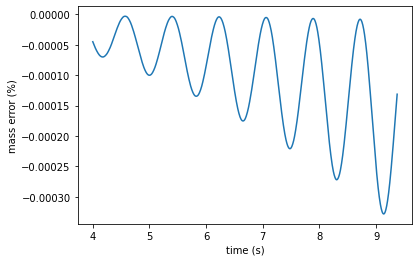

In [13]:
# plot wave elevation of a standing wave
mas = np.loadtxt("mass.dat", comments="#", delimiter=" ", unpack=False)
plt.figure(1)
plt.plot(mas[:,0],mas[:,1])
plt.xlabel('time (s)')
plt.ylabel('mass error (%)')

In [4]:
ffmpeg -i C%4d.png -v -8 C.gif

SyntaxError: invalid syntax (131033156.py, line 1)